# Getting Financial Data from SEC Edgar

## Automated processing using XBRL markup

Automated analysis of regulatory filings has become much easier since the SEC introduced XBRL, a free, open, and global standard for the electronic representation and exchange of business reports. XBRL is based on XML; it relies on taxonomies that define the meaning of the elements of a report and map to tags that highlight the corresponding information in the electronic version of the report. One such taxonomy represents the US Generally Accepted Accounting Principles (GAAP).

The SEC introduced voluntary XBRL filings in 2005 in response to accounting scandals before requiring this format for all filers since 2009 and continues to expand the mandatory coverage to other regulatory filings. The SEC maintains a website that lists the current taxonomies that shape the content of different filings and can be used to extract specific items.

There are several avenues to track and access fundamental data reported to the SEC:

As part of the EDGAR Public Dissemination Service (PDS), electronic feeds of accepted filings are available for a fee.
The SEC updates RSS feeds every 10 minutes, which list structured disclosure submissions.
There are public index files for the retrieval of all filings through FTP for automated processing.
The financial statement (and notes) datasets contain parsed XBRL data from all financial statements and the accompanying notes.
The SEC also publishes log files containing the internet search traffic for EDGAR filings through SEC.gov, albeit with a six-month delay.



## Building a fundamental data time series

The scope of the data in the Financial Statement and Notes datasets consists of numeric data extracted from the primary financial statements (Balance sheet, income statement, cash flows, changes in equity, and comprehensive income) and footnotes on those statements. The data is available as early as 2009.

The folder 03_sec_edgar contains the notebook edgar_xbrl to download and parse EDGAR data in XBRL format, and create fundamental metrics like the P/E ratio by combining financial statement and price data.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import h5py
from pandas import HDFStore

import requests, zipfile

In [3]:
sns.set_style('whitegrid')

In [4]:
data_path = Path('/Volumes/Seagate Backup Plus Drive/Parth Patel_Mac/SEC Data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

The following code downloads and extracts all historical filings contained in the Financial Statement and Notes (FSN) datasets for the given range of quarters:

Downloading 40GB of Data

In [5]:
SEC_URL = 'https://www.sec.gov/files/dera/data/financial-statement-and-notes-data-sets/'

In [6]:
today = pd.Timestamp(date.today())
this_year = today.year
this_quarter = today.quarter
past_years = range(2009, this_year)

In [7]:
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])


In [9]:

for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(f'{yr}-Q{qtr}', end=' ', flush=True)
    filing = f'{yr}q{qtr}_notes.zip'
    
    path = data_path / f'{yr}_{qtr}' / 'source'
    
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)
    
    response = requests.get(SEC_URL + filing).content
    
    try:

        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
                        
    except BadZipFile:
        print('got bad zip file')
        continue


2009-Q1 2009-Q2 2009-Q3 2009-Q4 2010-Q1 2010-Q2 2010-Q3 2010-Q4 2011-Q1 2011-Q2 2011-Q3 2011-Q4 2012-Q1 2012-Q2 2012-Q3 2012-Q4 2013-Q1 2013-Q2 2013-Q3 2013-Q4 2014-Q1 2014-Q2 2014-Q3 2014-Q4 2015-Q1 2015-Q2 2015-Q3 2015-Q4 2016-Q1 2016-Q2 2016-Q3 2016-Q4 2017-Q1 2017-Q2 2017-Q3 2017-Q4 2018-Q1 2018-Q2 2018-Q3 2018-Q4 2019-Q1 2019-Q2 2019-Q3 2019-Q4 2020-Q1 got bad zip file
2020-Q2 2020-Q3 got bad zip file
2020-Q4 got bad zip file


In [12]:
import dill as pickle
g = pickle.dumps(response)
pickle.loads(g)

b'<!DOCTYPE html>\n<html lang="en">\n\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge" />\n    <meta http-equiv="content-type" content="text/html; charset=utf-8">\n    <meta name="viewport" content="width=device-width initial-scale=1.0 maximum-scale=3.0" />\n    <meta name="origin" content="WCM" />\n    <script type="text/javascript">\n\t  WebFontConfig = {\n\t    google: { families: [ \'Raleway:300,400,500,600:latin\' ] }\n\t  };\n\t  (function() {\n\t    var wf = document.createElement(\'script\');\n\t    wf.src = \'//ajax.googleapis.com/ajax/libs/webfont/1/webfont.js\';\n\t    wf.type = \'text/javascript\';\n\t    wf.async = \'true\';\n\t    var s = document.getElementsByTagName(\'script\')[0];\n\t    s.parentNode.insertBefore(wf, s);\n\t  })(); </script>\n    \n    <title>SEC.gov | File Not Found Error Alert (404)</title>\n    <link rel="stylesheet" property="stylesheet" type=\'text/css\' href=\'/layout/short-app.css\' />\n    <link rel="stylesheet" property="style

# Finding the list of Companies(Sectorwise, CIK, Locationwise)

In [13]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [14]:
sp500_constituents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 9 columns):
Symbol                   505 non-null object
Security                 505 non-null object
SEC filings              505 non-null object
GICS Sector              505 non-null object
GICS Sub-Industry        505 non-null object
Headquarters Location    505 non-null object
Date first added         450 non-null object
CIK                      505 non-null int64
Founded                  496 non-null object
dtypes: int64(1), object(8)
memory usage: 35.6+ KB


In [15]:
sp500_constituents.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [16]:
Tech_stocks = sp500_constituents[sp500_constituents['GICS Sector'] == 'Information Technology']

In [17]:
Tech_stocks

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
6,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
7,AMD,Advanced Micro Devices Inc,reports,Information Technology,Semiconductors,"Santa Clara, California",2017-03-20,2488,1969
13,AKAM,Akamai Technologies Inc,reports,Information Technology,Internet Services & Infrastructure,"Cambridge, Massachusetts",2007-07-12,1086222,1998
38,APH,Amphenol Corp,reports,Information Technology,Electronic Components,"Wallingford, Connecticut",2008-09-30,820313,1932
39,ADI,"Analog Devices, Inc.",reports,Information Technology,Semiconductors,"Norwood, Massachusetts",1999-10-12,6281,1965
40,ANSS,ANSYS,reports,Information Technology,Application Software,"Canonsburg, Pennsylvania",2017-06-19,1013462,1969
46,AAPL,Apple Inc.,reports,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
47,AMAT,Applied Materials Inc.,reports,Information Technology,Semiconductor Equipment,"Santa Clara, California",1995-03-16,6951,1967
50,ANET,Arista Networks,reports,Information Technology,Communications Equipment,"Santa Clara, California",2018-08-28,1596532,2004


# Save to parquet¶


The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

In [62]:
for f in data_path.glob('**/*.tsv'):
    file_name = f.stem  + '.parquet'
    path = Path(f.parents[1]) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
        print(df)
    except:
        print(f)
    df.to_parquet(path / file_name)

In [81]:
sub = pd.read_parquet(data_path / '2020_2' / 'parquet' / 'sub.parquet')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16411 entries, 0 to 16410
Data columns (total 40 columns):
adsh           16411 non-null object
cik            16411 non-null int64
name           16411 non-null object
sic            16405 non-null float64
countryba      16394 non-null object
stprba         15137 non-null object
cityba         16393 non-null object
zipba          16384 non-null object
bas1           16394 non-null object
bas2           6591 non-null object
baph           16392 non-null object
countryma      16336 non-null object
stprma         15167 non-null object
cityma         16336 non-null object
zipma          16325 non-null object
mas1           16333 non-null object
mas2           6488 non-null object
countryinc     14973 non-null object
stprinc        14076 non-null object
ein            16411 non-null int64
former         9595 non-null object
changed        9595 non-null float64
afs            16373 non-null object
wksi           16411 non-null int64
fye     

# Get ADOBE submission¶

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Adobe's 2020Q2 10-Q filing:

In [109]:
cik = 796343
company = sub[sub.cik == cik].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
company.loc[key_cols]

name            ADOBE SYSTEMS INC
adsh         0000796343-13-000058
cik                        796343
name            ADOBE SYSTEMS INC
sic                          7372
countryba                      US
stprba                         CA
cityba                   SAN JOSE
zipba                  95110-2704
bas1                 345 PARK AVE
form                         10-Q
period                   20130831
fy                           2013
fp                             Q3
filed                    20131003
Name: 645, dtype: object

In [110]:
company_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    company_sub = sub[(sub.cik.astype(int) == cik) & (sub.form.isin(['10-Q', '10-K']))]
    company_subs = pd.concat([company_subs, company_sub])

In [111]:
company_subs.form.value_counts()

10-Q    33
10-K    10
Name: form, dtype: int64

In [112]:
company_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    company_num = num[num.adsh.isin(company_subs.adsh)]
    print(len(company_num))
    company_nums = pd.concat([company_nums, company_num])
company_nums.ddate = pd.to_datetime(company_nums.ddate, format='%Y%m%d')   
company_nums.to_parquet(data_path / 'company_nums.parquet')

2528
1075
1091
0
2517
1066
1089
0
2473
1034
1045
0
2323
989
997
0
2270
986
999
0
2539
1365
1418
0
1170
0
258
0
1170
355
1019
1257
1230
1803
2197
0
1226
2846
1114
1096
0
2606
1137
0
1161


In [126]:
g = pickle.dumps(company_nums)
pickle.loads(g)

,adsh,tag,version,ddate,qtrs,uom,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
6840,0000796343-14-000004,IncomeTaxExpenseBenefit,us-gaap/2013,2013-11-30,4,USD,0.0,6.615600e+07,None,0,0,None,0.021918,1.0,-3.0
6841,0000796343-14-000004,IncomeTaxExpenseBenefit,us-gaap/2013,2012-11-30,4,USD,0.0,2.860190e+08,None,0,0,None,0.021918,0.0,-3.0
6842,0000796343-14-000004,IncomeTaxExpenseBenefit,us-gaap/2013,2011-11-30,4,USD,0.0,2.023830e+08,None,0,0,None,0.021918,-2.0,-3.0
6843,0000796343-14-000004,StockIssuedDuringPeriodValueTreasuryStockReissued,us-gaap/2013,2011-11-30,4,USD,0.0,1.447540e+08,None,0,0,None,0.021918,-2.0,-3.0
6844,0000796343-14-000004,StockIssuedDuringPeriodValueTreasuryStockReissued,us-gaap/2013,2012-11-30,4,USD,0.0,1.692740e+08,None,0,0,None,0.021918,0.0,-3.0
6845,0000796343-14-000004,AccumulatedOtherComprehensiveIncomeLossAvailab...,us-gaap/2013,2013-11-30,0,USD,0.0,9.241000e+06,None,0,0,None,0.000000,1.0,-3.0
6846,0000796343-14-000004,AccumulatedOtherComprehensiveIncomeLossAvailab...,us-gaap/2013,2012-11-30,0,USD,0.0,1.443900e+07,None,0,0,None,0.000000,0.0,-3.0
6847,0000796343-14-000004,AvailableForSaleSecuritiesDebtMaturitiesWithin...,us-gaap/2013,2013-11-30,0,USD,0.0,5.094380e+08,None,0,0,None,0.000000,1.0,-3.0
6848,0000796343-14-000004,ProceedsFromSaleOfPropertyHeldForSale,us-gaap/2013,2013-11-30,1,USD,0.0,2.430000e+07,None,0,0,None,0.013699,1.0,-5.0
6849,0000796343-14-000004,AvailableForSaleSecuritiesInUnrealizedLossPosi...,0000796343-14-000004,2012-11-30,0,securities,0.0,6.500000e+01,None,0,0,None,0.000000,0.0,0.0


In [113]:
company_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49449 entries, 6840 to 5092764
Data columns (total 15 columns):
adsh        49449 non-null object
tag         49449 non-null object
version     49449 non-null object
ddate       49449 non-null datetime64[ns]
qtrs        49449 non-null object
uom         49449 non-null object
iprx        49449 non-null float64
value       49409 non-null float64
footnote    523 non-null object
footlen     49449 non-null object
dimn        49449 non-null object
coreg       0 non-null object
durp        49449 non-null float64
datp        49449 non-null float64
dcml        49449 non-null float64
dtypes: datetime64[ns](1), float64(5), object(9)
memory usage: 6.0+ MB


# Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.



In [114]:
stock_split = 0
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

In [115]:
# Filter by tag; keep only values measuring 1 quarter
eps = company_nums[(company_nums.tag == 'EarningsPerShareDiluted')
                & (company_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

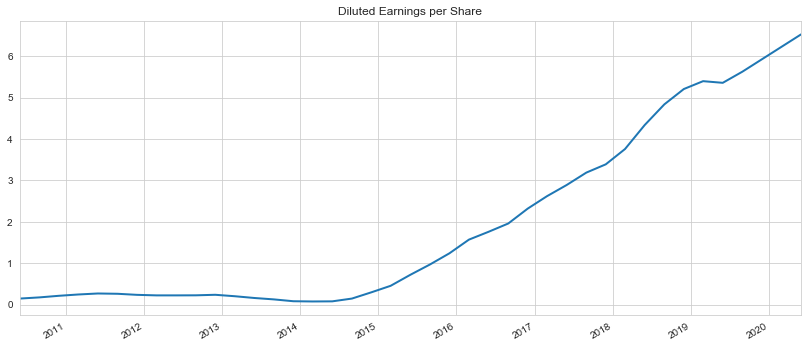

In [116]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [117]:
symbol = 'ADBE.US'
 

company_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min(), 
                         end = eps.index.max(),
                         api_key = 'J8qrR58jz1huGcFxGuqh')
              .resample('D')
              .last()
             .loc['2009':eps.index.max()])
company_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2857 entries, 2010-06-01 to 2018-03-27
Freq: D
Data columns (total 12 columns):
Open          1968 non-null float64
High          1968 non-null float64
Low           1968 non-null float64
Close         1968 non-null float64
Volume        1968 non-null float64
ExDividend    1968 non-null float64
SplitRatio    1968 non-null float64
AdjOpen       1968 non-null float64
AdjHigh       1968 non-null float64
AdjLow        1968 non-null float64
AdjClose      1968 non-null float64
AdjVolume     1968 non-null float64
dtypes: float64(12)
memory usage: 290.2 KB


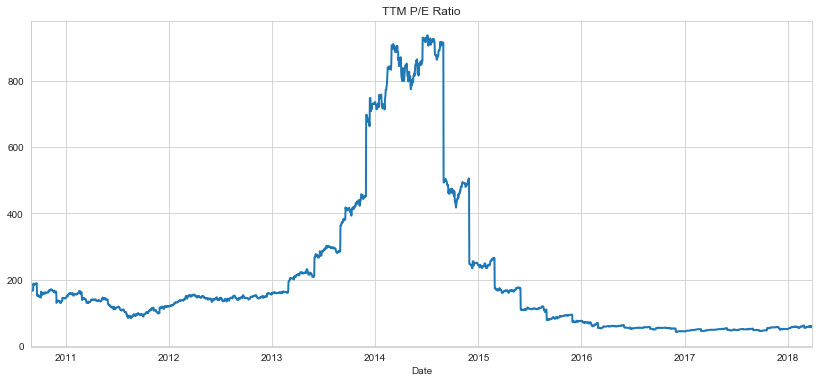

In [118]:
pe = company_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');


In [119]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2766 entries, 2010-08-31 to 2018-03-27
Freq: D
Data columns (total 3 columns):
price        2766 non-null float64
eps          2766 non-null float64
P/E Ratio    2766 non-null float64
dtypes: float64(3)
memory usage: 86.4 KB


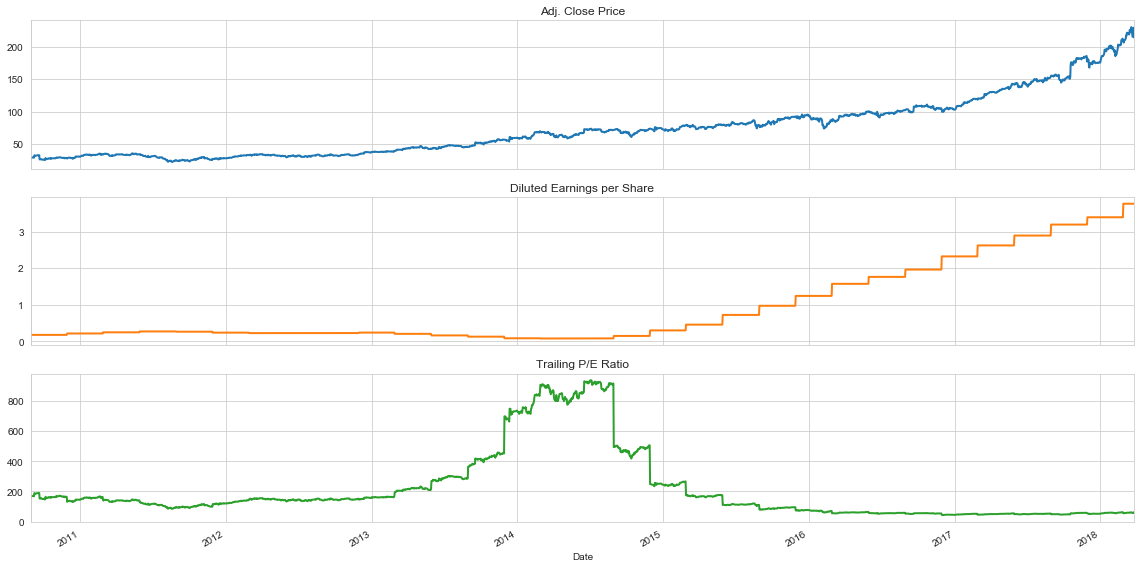

In [120]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

# Explore Additional Fields

In [121]:
company_nums.tag.value_counts()

AllocatedShareBasedCompensationExpense                                                                         1415
CashAndCashEquivalentsFairValueDisclosure                                                                      1385
AvailableForSaleSecurities                                                                                     1315
AvailableForSaleSecuritiesAmortizedCost                                                                        1078
Revenues                                                                                                        830
GrossProfit                                                                                                     717
FiniteLivedIntangibleAssetsNet                                                                                  712
CostOfRevenue                                                                                                   645
AvailableForSaleSecuritiesFairValueDisclosure                           

In [143]:
type(company_nums.tag.value_counts())

pandas.core.series.Series

In [150]:
company_nums.tag.value_counts().to_csv() 

'AllocatedShareBasedCompensationExpense,1415\nCashAndCashEquivalentsFairValueDisclosure,1385\nAvailableForSaleSecurities,1315\nAvailableForSaleSecuritiesAmortizedCost,1078\nRevenues,830\nGrossProfit,717\nFiniteLivedIntangibleAssetsNet,712\nCostOfRevenue,645\nAvailableForSaleSecuritiesFairValueDisclosure,632\nFiniteLivedIntangibleAssetsGross,632\nFiniteLivedIntangibleAssetsAccumulatedAmortization,632\nGrossProfitAsPercentageOfRevenue,620\nShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsNonvestedNumber,480\nStockholdersEquity,474\nAvailableForSaleSecuritiesAccumulatedGrossUnrealizedGainBeforeTax,444\nAvailableForSaleSecuritiesAccumulatedGrossUnrealizedLossBeforeTax,444\nAvailableForSaleSecuritiesContinuousUnrealizedLossPositionLessThanTwelveMonthsFairValue,416\nShortTermInvestments,338\nNetIncomeLoss,323\nAvailableForSaleSecuritiesGrossUnrealizedGains,309\nAvailableForSaleSecuritiesGrossUnrealizedLoss,302\nAvailableforsaleSecuritiesGrossUnrealize

In [188]:
# # Filter by tag; keep only values measuring 1 quarter
# import ddate
# current_liabilities = company_nums[(company_nums.tag == 'LiabilitiesCurrent',['ddate', 'value'])]
# current_assets = company_nums[(company_nums.tag == 'AssetsCurrent',['ddate', 'value'])]
# current_ratio  = [(current_assets / current_liabilities)]
      

# Keep only most recent data point from each filing
#eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))


#eps = eps.rolling(4,min_periods=4).sum().dropna()

TypeError: '(6840       False
6841       False
6842       False
6843       False
6844       False
6845       False
6846       False
6847       False
6848       False
6849       False
6850       False
6851       False
6852       False
6853       False
6854       False
6855       False
6856       False
6857       False
6858       False
6859       False
37077      False
37078      False
37079      False
37080      False
37081      False
37082      False
37083      False
37084      False
37085      False
37086      False
           ...  
5092728    False
5092729    False
5092730    False
5092731    False
5092732    False
5092733    False
5092734    False
5092735    False
5092736    False
5092737    False
5092738    False
5092739    False
5092740    False
5092741    False
5092742    False
5092744    False
5092745    False
5092750    False
5092752    False
5092754    False
5092755    False
5092756    False
5092757    False
5092758    False
5092759    False
5092760    False
5092761    False
5092762    False
5092763    False
5092764    False
Name: tag, Length: 49449, dtype: bool, ['ddate', 'value'])' is an invalid key

In [122]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

# Dividends per Share

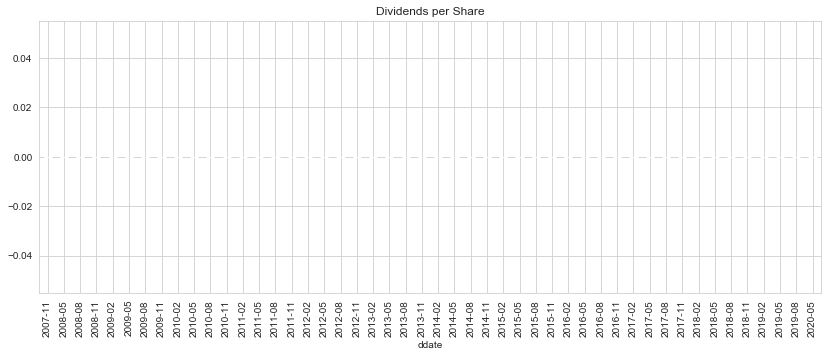

In [123]:
dividends = (company_nums
             .loc[company_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (company_nums
          .loc[company_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares) #.dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))


# Bonus: Textual Information¶

In [124]:
txt = pd.read_parquet(data_path / '2020_2' / 'parquet' /  'txt.parquet')

In [125]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000006201-20-000051,AmendmentFlag,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0x00000000,0,None,0,5,5,None,0,D2020Q2,false
1,0000006201-20-000051,AmendmentFlag,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0xbcb3e4b456b208133382b5ccc841019f,1,None,0,5,5,None,0,D2020Q2_srt_ConsolidatedEntitiesAxis_srt_Subsi...,false
2,0000006201-20-000051,EntityCentralIndexKey,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0x00000000,0,None,0,10,10,None,0,D2020Q2,0000006201
3,0000006201-20-000051,EntityCentralIndexKey,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0xbcb3e4b456b208133382b5ccc841019f,1,None,0,10,10,None,0,D2020Q2_srt_ConsolidatedEntitiesAxis_srt_Subsi...,0000004515
4,0000006201-20-000051,DocumentType,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0x00000000,0,None,0,3,3,None,0,D2020Q2,8-K
